In [22]:
# --- 1. Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchsummary import summary  # pip install torchsummary
import random

In [23]:
# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [24]:
# --- 3. Data Directories ---
data_dir = r'D:\00_google_classroom\pytorch\PlantVillage'
splitted_data_dir = r'D:\00_google_classroom\pytorch'

In [25]:
# --- 4. Image Transformations ---
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1]
])

In [26]:

# --- 5. Load Datasets ---
batch_size = 32
train_dataset = datasets.ImageFolder(root=os.path.join(splitted_data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(splitted_data_dir, "valid"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(splitted_data_dir, "test"),  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes: {train_dataset.classes}")

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


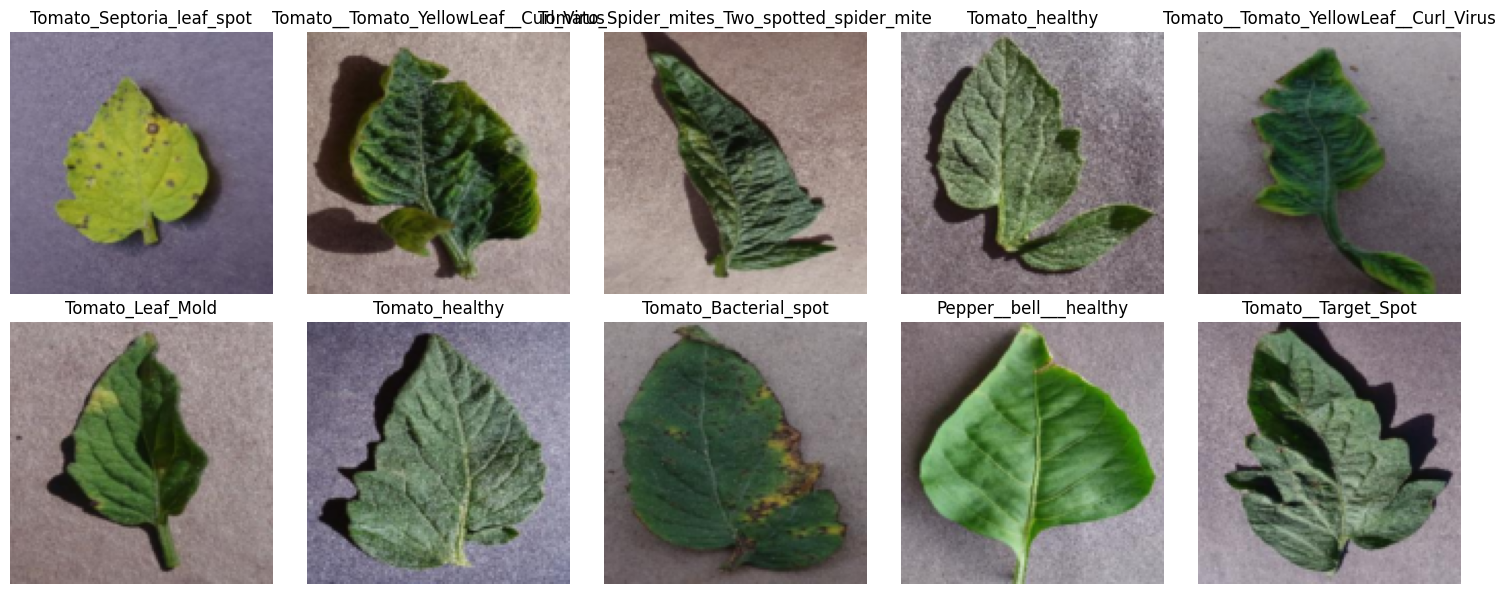

In [36]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize if normalized to [-1, 1]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 6))
for i in range(10):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    plt.subplot(2, 5, i+1)
    imshow(img, title=train_dataset.classes[label])
plt.tight_layout()
plt.show()

In [28]:

# --- 7. Model Definition ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * (img_size // 8) * (img_size // 8), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
print(model)
summary(model, (3, img_size, img_size))

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=15, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]       

In [29]:
# --- 8. Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# --- 9. Training and Validation Functions ---
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
# --- 10. Training Loop ---
num_epochs = 10
train_losses, val_accuracies = [], []
train_accuracies, val_losses = [], []

def compute_loss(model, loader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(loader)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = compute_loss(model, valid_loader, criterion)
    train_acc = evaluate(model, train_loader)
    val_acc = evaluate(model, valid_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    checkpoint_path = f"plant_cnn_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

Epoch 1/10, Train Loss: 1.2528, Train Acc: 0.8178, Val Loss: 0.5842, Val Acc: 0.8059
Model saved to plant_cnn_epoch1.pth
Epoch 2/10, Train Loss: 0.6578, Train Acc: 0.8860, Val Loss: 0.4373, Val Acc: 0.8571
Model saved to plant_cnn_epoch2.pth
Epoch 3/10, Train Loss: 0.4748, Train Acc: 0.8905, Val Loss: 0.4361, Val Acc: 0.8566
Model saved to plant_cnn_epoch3.pth
Epoch 4/10, Train Loss: 0.3666, Train Acc: 0.9514, Val Loss: 0.2677, Val Acc: 0.9098
Model saved to plant_cnn_epoch4.pth
Epoch 5/10, Train Loss: 0.2858, Train Acc: 0.9713, Val Loss: 0.2243, Val Acc: 0.9294
Model saved to plant_cnn_epoch5.pth
Epoch 6/10, Train Loss: 0.2428, Train Acc: 0.9737, Val Loss: 0.2364, Val Acc: 0.9195
Model saved to plant_cnn_epoch6.pth
Epoch 7/10, Train Loss: 0.1982, Train Acc: 0.9848, Val Loss: 0.2076, Val Acc: 0.9352
Model saved to plant_cnn_epoch7.pth
Epoch 8/10, Train Loss: 0.1914, Train Acc: 0.9806, Val Loss: 0.2265, Val Acc: 0.9279
Model saved to plant_cnn_epoch8.pth
Epoch 9/10, Train Loss: 0.1411, 

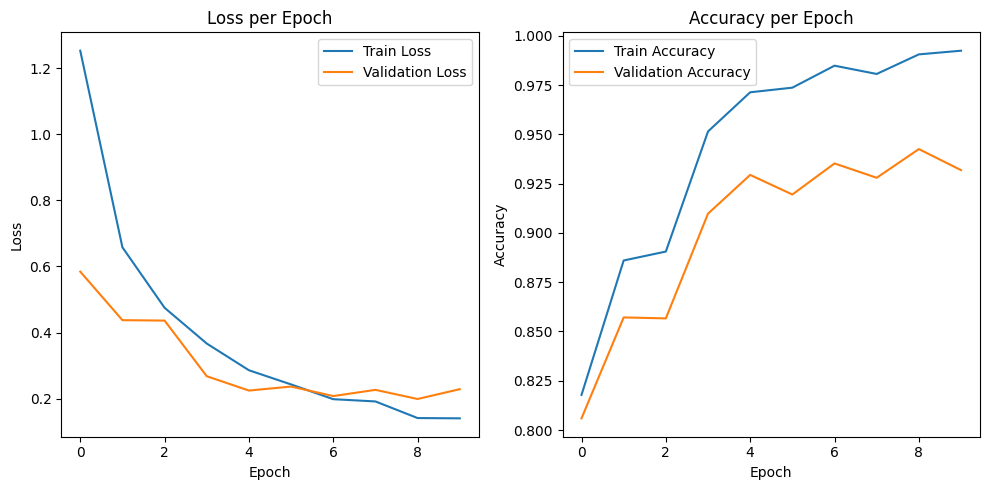

In [32]:
# --- 11. Plot Training History ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

plt.tight_layout()
plt.show()

In [33]:
# --- 12. Testing and Evaluation ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))



Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.88      0.91       200
                     Pepper__bell___healthy       0.99      0.92      0.95       297
                      Potato___Early_blight       0.95      0.96      0.96       200
                       Potato___Late_blight       0.85      0.96      0.90       200
                           Potato___healthy       0.63      0.87      0.73        31
                      Tomato_Bacterial_spot       0.94      0.99      0.96       426
                        Tomato_Early_blight       0.91      0.71      0.80       200
                         Tomato_Late_blight       0.91      0.89      0.90       383
                           Tomato_Leaf_Mold       0.98      0.90      0.94       191
                  Tomato_Septoria_leaf_spot       0.85      0.95      0.90       355
Tomato_Spider_mites_Two_spotted_spider_m

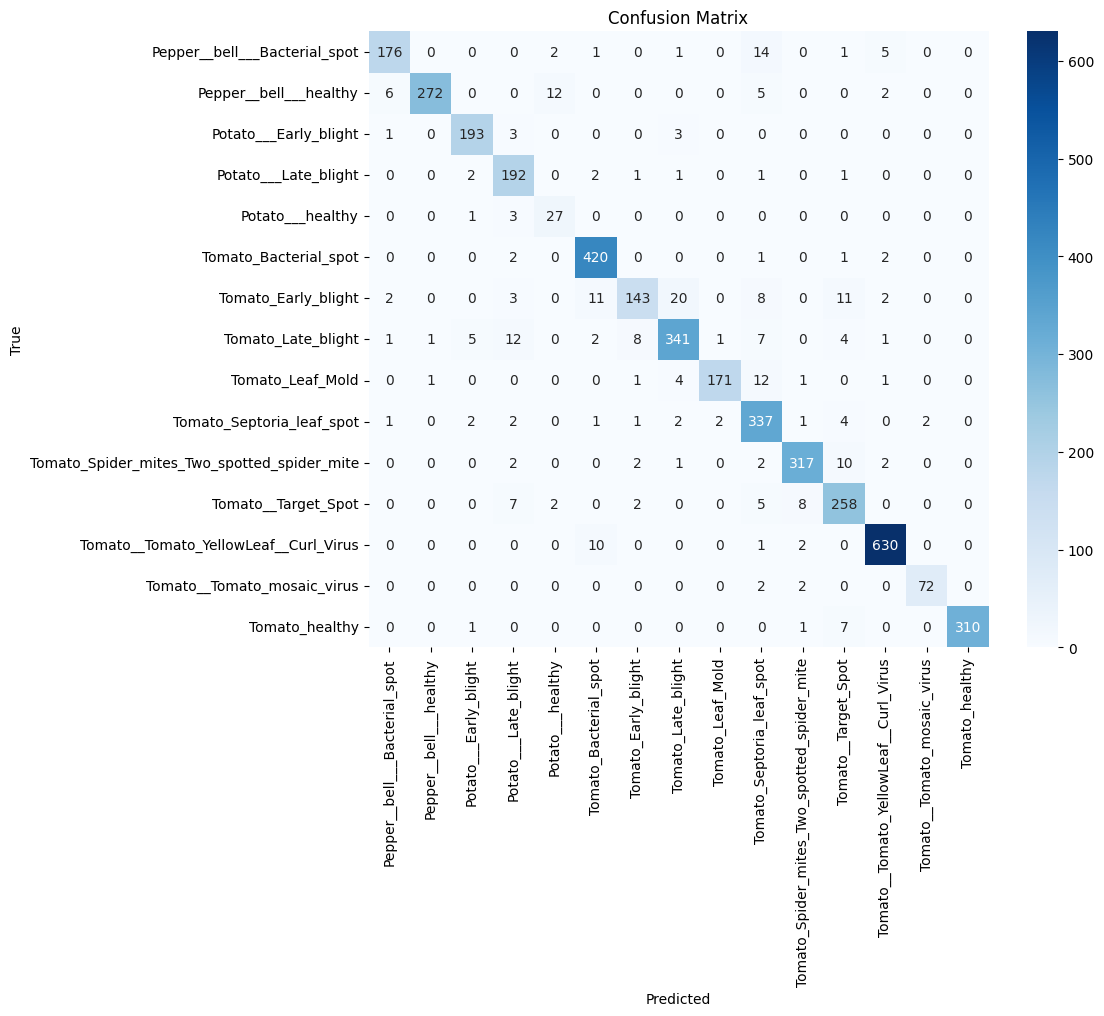

In [34]:
# --- 13. Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

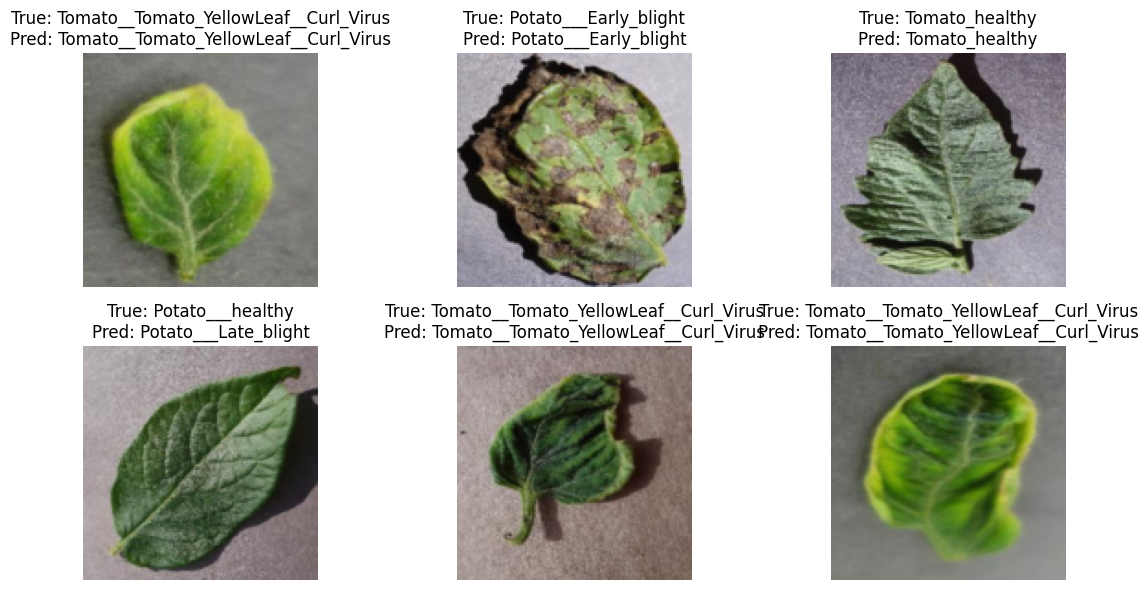

In [64]:
# --- 14. Show Random Sample Predictions from Test Set ---
def show_random_predictions(model, dataset, class_names, num_images=6):
    model.eval()
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(dataset)), num_images)
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, label = dataset[idx]
            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)
            img_disp = img.cpu()
            true_label = class_names[label]
            pred_label = class_names[pred.item()]
            plt.subplot(2, num_images//2, i+1)
            imshow(img_disp, title=f"True: {true_label}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

show_random_predictions(model, test_dataset, train_dataset.classes, num_images=6)